### Load the WSEAD dataset

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from scipy.stats import mode

# Get path to WESAD folder
current_directory = os.getcwd()
folder_name = "data/WESAD"
folder_path = os.path.join(current_directory, folder_name)

# Make sure it exists
if not (os.path.exists(folder_path) and os.path.isdir(folder_path)):
    print(f"The folder '{folder_name}' does not exist in the current directory.")
else:
    # List everything in the folder just to make sure
    print("Contents of folder:", folder_name)
    for item in os.listdir(folder_path):
        print(item)

Contents of folder: data/WESAD
S5
S2
S3
S4
.DS_Store
S17
S10
S11
S16
S8
S6
S7
S9
S13
S14
S15
wesad_readme.pdf


### For each subject, get the synchronized data in SX.pkl, one file per subject. 

The double-tap signal pattern was used to manually synchronise the two devices’ raw data. This file is a dictionary, with the following
keys:
- ‘subject’: SX, the subject ID
- ‘signal’: includes all the raw data, in two fields:
    - ‘chest’: RespiBAN data (all the modalities: ACC, ECG, EDA, EMG, RESP, TEMP)
    - ‘wrist’: Empatica E4 data (all the modalities: ACC, BVP, EDA, TEMP)
- ‘label’: ID of the respective study protocol condition, sampled at 700 Hz. The following IDs are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset

In [2]:
valid_subjects = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
subject_num = 2

# The path to the pickle file for this subject
pickle_file_path = f"data/WESAD/S{subject_num}/S{subject_num}.pkl"

try:
    # Open the pickle file in read-binary mode and load the data
    with open(pickle_file_path, "rb") as f:
        loaded_data = pickle.load(f, encoding='latin1')
    
    print(f"Data loaded successfully from the pickle file for Subject {subject_num}:")
    for field in loaded_data:
        print(field)

except FileNotFoundError:
    print("The specified pickle file does not exist.")
except Exception as e:
    print("An error occurred while loading data from the pickle file:", e)

Data loaded successfully from the pickle file for Subject 2:
signal
label
subject


### Segmentation functions are defined here for now

In [3]:
def segment_data(data, sampling_rate=700, segment_length=2, window_stride=0.25):
    """
    Segment the given data array into 2-second segments with a sliding window of 0.25 seconds.
    
    Args:
    - data: The data array.
    - sampling_rate: The sampling rate of the data in Hz (default: 700 Hz).
    - segment_length: The length of each segment in seconds (default: 2 seconds).
    - window_stride: The stride of the sliding window in seconds (default: 0.25 seconds).
    
    Returns:
    - segments: A list of segmented data arrays.
    """
    
    segments = []
    start_index = 0
    end_index = int(segment_length * sampling_rate)
    window_stride_samples = int(window_stride * sampling_rate)
    
    while end_index <= len(data):
        segments.append(data[start_index:end_index])
        start_index += window_stride_samples
        end_index += window_stride_samples
    
    return segments


def segment_labels(labels, sampling_rate=700, segment_length=2, window_stride=0.25):
    """
    Segment the labels into 2-second segments with a sliding window of 0.25 seconds.
    
    Args:
    - labels: The labels array.
    - sampling_rate: The sampling rate of the data in Hz (default: 700 Hz).
    - segment_length: The length of each segment in seconds (default: 2 seconds).
    - window_stride: The stride of the sliding window in seconds (default: 0.25 seconds).
    
    Returns:
    - seg_labels: A list containing the majority label for each segment.
    - label_fractions: A list indicating what fraction of the segment the label 
    applies to (maybe useful if a label boundary falls in the middle of the segment)
    """

    seg_labels = []
    label_fractions = []
    start_index = 0
    end_index = int(segment_length * sampling_rate)
    window_stride_samples = int(window_stride * sampling_rate)
    
    while end_index <= len(data):
        seg_label, label_count = mode(labels[start_index:end_index])
        seg_labels.append(seg_label)
        label_fractions.append(label_count/(end_index-start_index))
        start_index += window_stride_samples
        end_index += window_stride_samples
    
    return seg_labels, label_fractions

### Segment the data and make some plots

Chest data is at 700Hz

Labels (the ID of the respective study protocol condition)
- 0 = not defined / transient
- 1 = baseline
- 2 = stress
- 3 = amusement
- 4 = meditation
- 5/6/7 = should be ignored in this dataset

In [4]:
chest_data_types = ["ACC", "ECG", "EDA", "EMG", "Resp", "Temp"]  
chest_data = loaded_data["signal"]["chest"]
raw_labels = loaded_data["label"]
segmented_data_dict = {}

segment_length = 60 # in seconds
window_stride = 0.25 # in seconds (segment_length = window_stride means no overlap between windows)

# Segment the data
for data_type in chest_data_types:
    data = chest_data[data_type] 
    segments = segment_data(data, 700, segment_length, window_stride)
    segmented_data_dict[data_type] = segments

# Segment the labels
seg_labels, label_fracs = segment_labels(raw_labels, 700, segment_length, window_stride)
segmented_data_dict["labels"] = seg_labels
segmented_data_dict["label_fracs"] = label_fracs


In [5]:
def remove_unused_segments(segmented_data, labels):
    return 0

SyntaxError: incomplete input (3409446880.py, line 2)

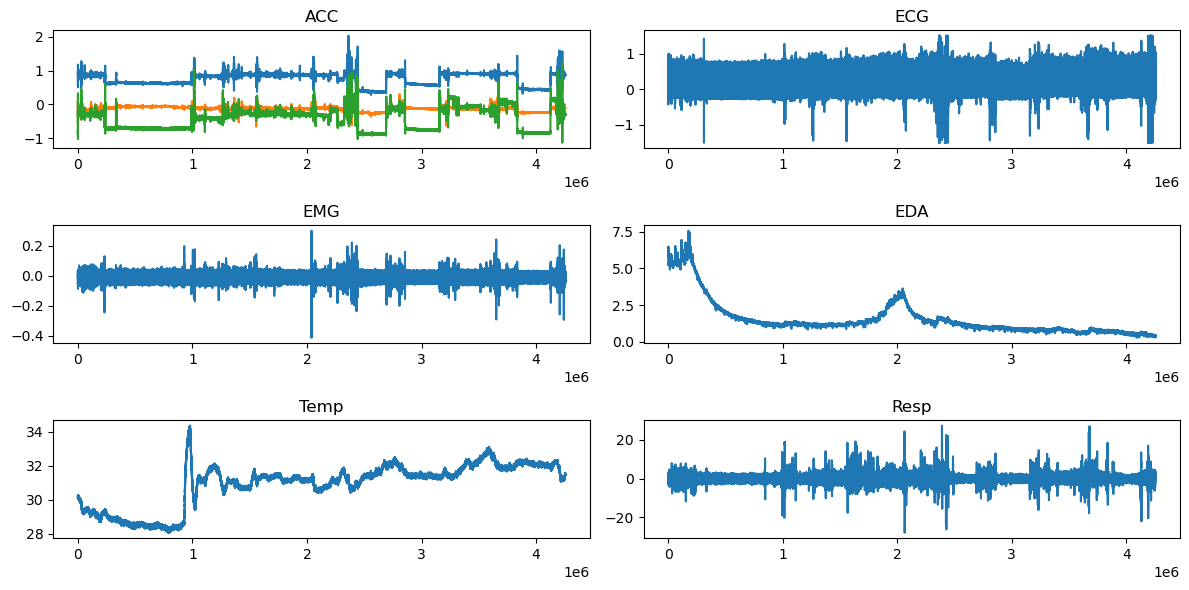

'\nfig, axs = plt.subplots(3, 2, figsize=(12, 6))\nfor i, key in enumerate(chest_data.keys()):\n    if not key == "ACC":\n        row_index = i // 2\n        col_index = i % 2\n        ax = axs[row_index, col_index]\n        ax.specgram(chest_data[key], Fs=700)\n        ax.set_title(key)\n        ax.set_xlabel(\'Time (s)\')\n        ax.set_ylabel(\'Frequency (Hz)\')\n        #ax.colorbar()\nplt.tight_layout()\nplt.show()\n'

In [6]:
# Make some plots of raw data (sanity check)
fig, axs = plt.subplots(3, 2, figsize=(12, 6))
for i, key in enumerate(chest_data.keys()):
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index, col_index]
    ax.plot(chest_data[key])
    ax.set_title(key)
plt.tight_layout()
plt.show()


# Plot the spectrogram
"""
fig, axs = plt.subplots(3, 2, figsize=(12, 6))
for i, key in enumerate(chest_data.keys()):
    if not key == "ACC":
        row_index = i // 2
        col_index = i % 2
        ax = axs[row_index, col_index]
        ax.specgram(chest_data[key], Fs=700)
        ax.set_title(key)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        #ax.colorbar()
plt.tight_layout()
plt.show()
"""

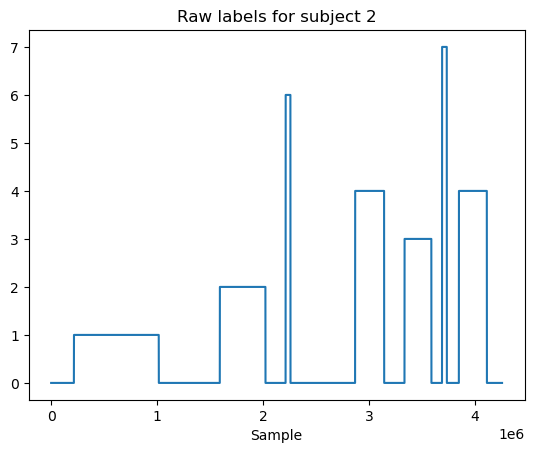

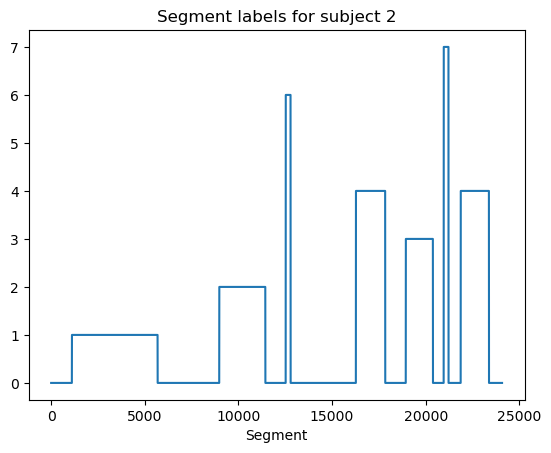

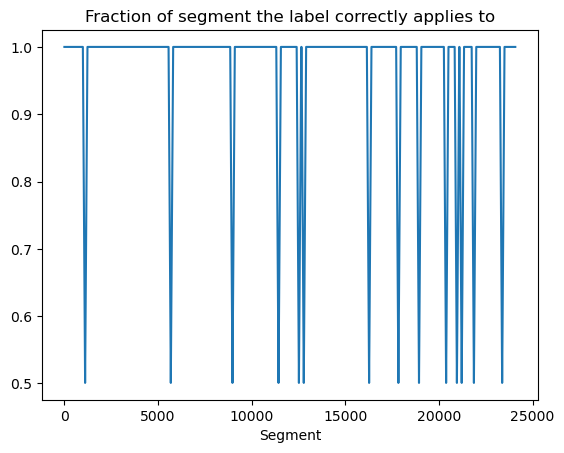

In [7]:
# Make some plots of labels (sanity check for label segmentation)
plt.plot(raw_labels)
plt.title(f"Raw labels for subject {subject_num}")
plt.xlabel("Sample")
plt.show()

plt.plot(seg_labels)
plt.title(f"Segment labels for subject {subject_num}")
plt.xlabel("Segment")
plt.show()

plt.plot(label_fracs)
plt.title(f"Fraction of segment the label correctly applies to")
plt.xlabel("Segment")
plt.show()

In [8]:
# Sanity check
for field in segmented_data_dict:
    print(field)
    print(len(segmented_data_dict[field]))

ACC
24077
ECG
24077
EDA
24077
EMG
24077
Resp
24077
Temp
24077
labels
24077
label_fracs
24077


### Feature Extraction
Using the featues detailed in the "Introducing WESAD" paper

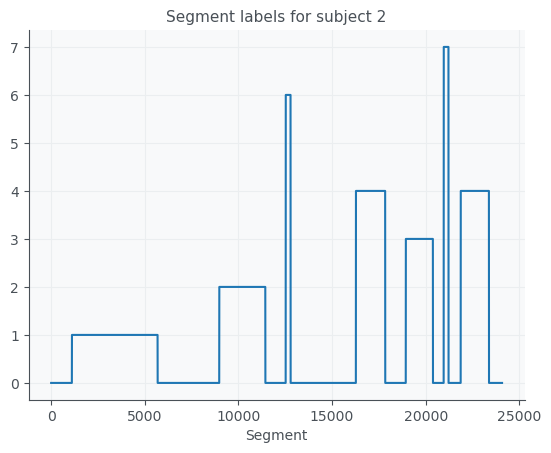

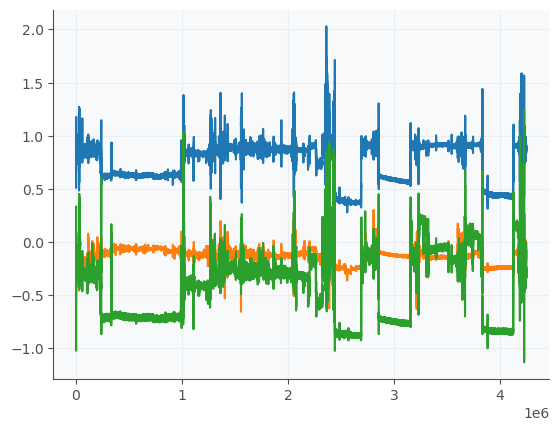

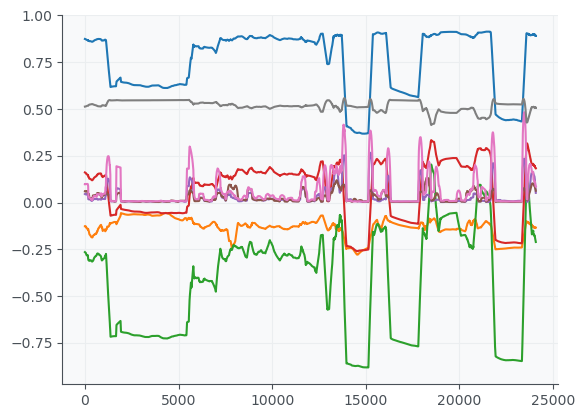

In [10]:
import numpy as np
from biosppy.signals import ecg

def get_ACC_features(data):
    """
    Calculate the mean and standard deviation for each axis separately
    and summed across all axes. Calculate the absolute integral for each axis.

    """

    axis0 = data[:,0]
    axis1 = data[:,1]
    axis2 = data[:,2]
    
    # absolute integral for each axis
    #np.sum(np.abs(data))
    
    features = [np.mean(axis0), np.mean(axis1), np.mean(axis2), np.mean(data), np.std(axis0), np.std(axis1), np.std(axis2), np.std(data)]

    return features

# get ACC features
acc_data = segmented_data_dict["ACC"]
acc_features = np.zeros((len(acc_data),8))
for i in range(len(acc_data)):
    acc_features[i, :] = get_ACC_features(segmented_data_dict["ACC"][i])

plt.plot(seg_labels)
plt.title(f"Segment labels for subject {subject_num}")
plt.xlabel("Segment")
plt.show()

plt.plot(chest_data["ACC"])
plt.show()

plt.plot(acc_features)
plt.show()

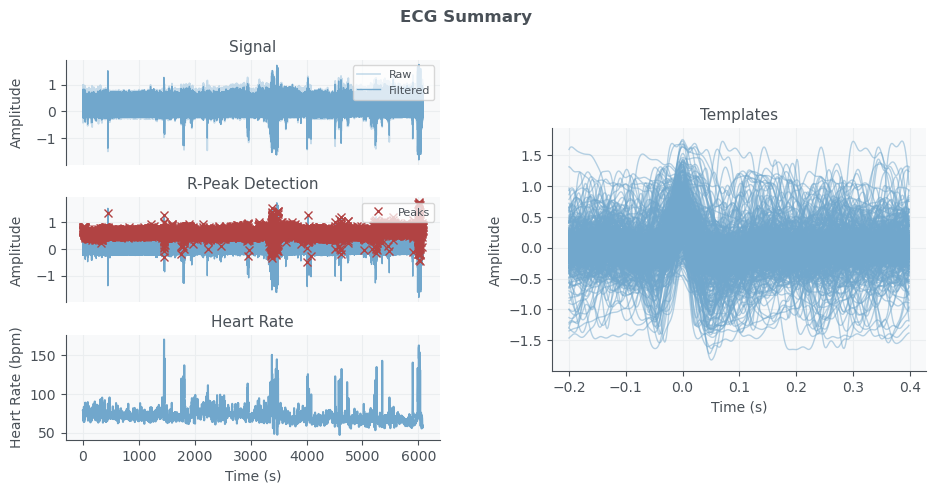

Heart rate (beats per minute): [77.63401109 82.51473477 78.35820896 ... 57.61316872 58.01104972
 59.65909091]


In [11]:
# Process ECG data

ecgdata = chest_data["ECG"]
ecg_result = ecg.ecg(signal=ecgdata.flatten(), sampling_rate=700, show=True)

# Get the R-peak locations and heart rate
r_peaks = ecg_result['rpeaks']
heart_rate_intervals = np.diff(r_peaks) / 700
heart_rate = 60 / heart_rate_intervals  # Convert time intervals to heart rate (beats per minute)

print("Heart rate (beats per minute):", heart_rate)

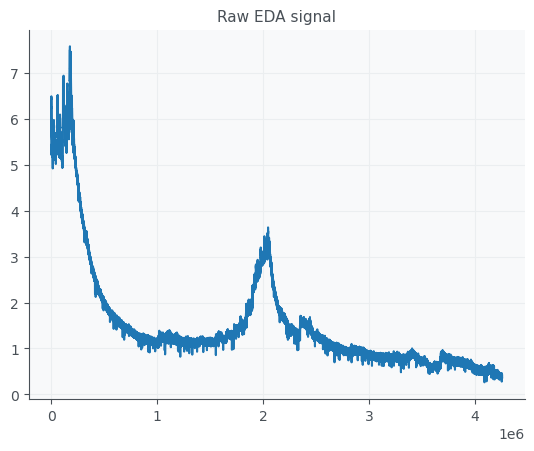

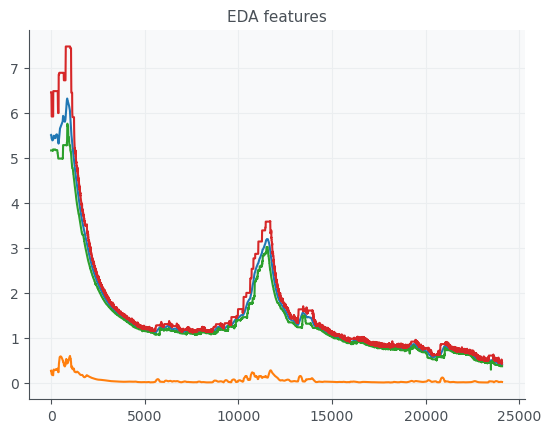

In [12]:
# Process EDA data
from scipy.signal import butter, filtfilt

def get_EDA_features(data):
    """
    First apply a 5 Hz lowpass filter (as in the WESAD paper). 
    Then calculate the mean, standard deviation, min, max.

    """
    
    # Define filter parameters
    lowcut = 5  # Low cutoff frequency in Hz
    fs = 700  # Sampling frequency in Hz
    order = 4  # Filter order

    # Normalize the cutoff frequency with respect to the Nyquist frequency
    low = lowcut / (0.5 * fs)

    # Design a lowpass Butterworth filter
    b, a = butter(order, low, btype='low')

    # Apply the filter to the raw EDA signal
    filtered_eda_signal = filtfilt(b, a, data)
    
    features = [np.mean(filtered_eda_signal), np.std(filtered_eda_signal), np.min(filtered_eda_signal), np.max(filtered_eda_signal)]

    return features

eda_data = segmented_data_dict["EDA"]
eda_features = np.zeros((len(eda_data),4))
for i in range(len(eda_data)):
    eda_features[i, :] = get_EDA_features(segmented_data_dict["EDA"][i].flatten())
    
plt.plot(chest_data["EDA"])
plt.title("Raw EDA signal")
plt.show()

plt.plot(eda_features)
plt.title("EDA features")
plt.show()

Other stuff lives down here in the graveyard

In [ ]:
# if needed to download. but we already have the file saved so

import urllib.request

wesad_url = ("https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download")
filename = "wesad.zip"

#urllib.request.urlretrieve(wesad_url, filename)